In [20]:
%reload_ext autoreload
%autoreload 2

In [17]:
import os
import sys
import json
import random
import pickle
from datetime import datetime
from glob import glob
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import h5py
import obspy
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from scipy import stats, signal
from tqdm import tqdm
from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms

# Add custom module path
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom utilities and models
import seis_feature
from utils import apply_cosine_taper, butterworth_filter, resample_array
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

# Download dataset from Zenodo
doi = '10.5281/zenodo.13334838'
from zenodo_get import zenodo_get
files = zenodo_get([doi])

# Import classification functions
from all_models_classification import (
    compute_window_probs, plot_single_model_probs, plot_all_model_probs
)




Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB
best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_30_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_100_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB
best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib is already downloaded correctly.

Link:

In [6]:
device


device(type='cuda')

## Loading the machine learning models

In [7]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cpu"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_959104/2063820159.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_Seis

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## Parameters to provide

In [13]:
# Define start and end times for the seismic event
start_time = obspy.UTCDateTime(2024, 8, 15, 17, 39, 52)  # UTC start time
end_time = start_time + 300  # End time, 300 seconds (5 minutes) after start time

# List of station IDs for seismic data collection
stations_id = ['CC.WOW', 'CC.TAVI', 'CC.GNOB', 'CC.ARAT', 'CC.TABR', 'UW.RER']

# Location wildcard, used to match all available locations for the given stations
location = "*"


## Computation of the probabilities

In [22]:
# Initialize client for accessing IRIS web services
client = Client("IRIS")

# Define parameters for signal processing
orig_sr = 100  # Original sampling rate in Hz
new_sr = 50    # New sampling rate in Hz
stride = 10 * orig_sr  # Stride value for processing windows (10 times original sampling rate)
lowpass = 1  # Lowpass filter cutoff frequency in Hz
highpass = 20  # Highpass filter cutoff frequency in Hz
window_length = 100  # Length of the window for processing in samples
channel_patterns = ["EH", "BH", "HH"]  # Channel patterns to filter

# Function to process and compute probabilities for seismic models
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    """
    This function computes the probabilities for a given model, station data, and time window.
    
    Args:
        model: The model used for classification (e.g., deep learning or machine learning).
        stations_id: List of station IDs for data collection.
        location: Location of the station (wildcard "*" to match all locations).
        start_time: Start time of the seismic event (obspy.UTCDateTime object).
        end_time: End time of the seismic event (obspy.UTCDateTime object).
        one_d: Boolean indicating whether the model is 1D or 2D.
        model_type: Type of the model, either 'dl' for deep learning or 'ml' for machine learning.
        filename: Name of the output file to save results.
    
    Returns:
        tuple: Processed probabilities and other output data.
    """
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )

# Compute probabilities for different deep learning models

# 1D model: QuakexNet
stn_probs_quakexnet_1d, _, big_station_ids = process_model(
    model_quakexnet_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: QuakexNet
stn_probs_quakexnet_2d, big_reshaped_data, _ = process_model(
    model_quakexnet_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 1D model: SeismicCNN
stn_probs_seismiccnn_1d, _, _ = process_model(
    model_seismiccnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: SeismicCNN
stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# Machine Learning model probabilities
# The model parameter is irrelevant for ML models (use any model)
model = model_quakexnet_1d  # Example ML model

# 40 Hz frequency model (ML)
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)

# 110 Hz frequency model (ML)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)

# 150 Hz frequency model (ML)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:02<00:10,  2.16s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:03<00:07,  1.91s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:06<00:06,  2.17s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:08<00:04,  2.15s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:10<00:02,  2.16s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:01<00:09,  1.89s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:03<00:07,  1.89s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:05<00:05,  1.86s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:07<00:03,  1.89s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:09<00:01,  1.89s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:01<00:07,  1.43s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:02<00:05,  1.33s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:04<00:04,  1.37s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:05<00:03,  1.50s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:07<00:01,  1.63s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:01<00:06,  1.38s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:04<00:04,  1.35s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:05<00:02,  1.33s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:06<00:01,  1.32s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:03<00:15,  3.17s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:06<00:13,  3.43s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:10<00:10,  3.50s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:13<00:06,  3.48s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:17<00:03,  3.43s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:03<00:15,  3.04s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:06<00:12,  3.01s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:08<00:08,  2.82s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:11<00:05,  2.77s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:14<00:03,  3.00s/it]

Reshaped data: (1, 3, 30000)


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)


 17%|█▋        | 1/6 [00:02<00:12,  2.55s/it]

Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:05<00:10,  2.67s/it]

Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:07<00:07,  2.44s/it]

Reshaped data: (1, 3, 30000)


 67%|██████▋   | 4/6 [00:10<00:05,  2.57s/it]

Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:12<00:02,  2.60s/it]

Reshaped data: (1, 3, 30000)


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


## Plotting probabilities from all models

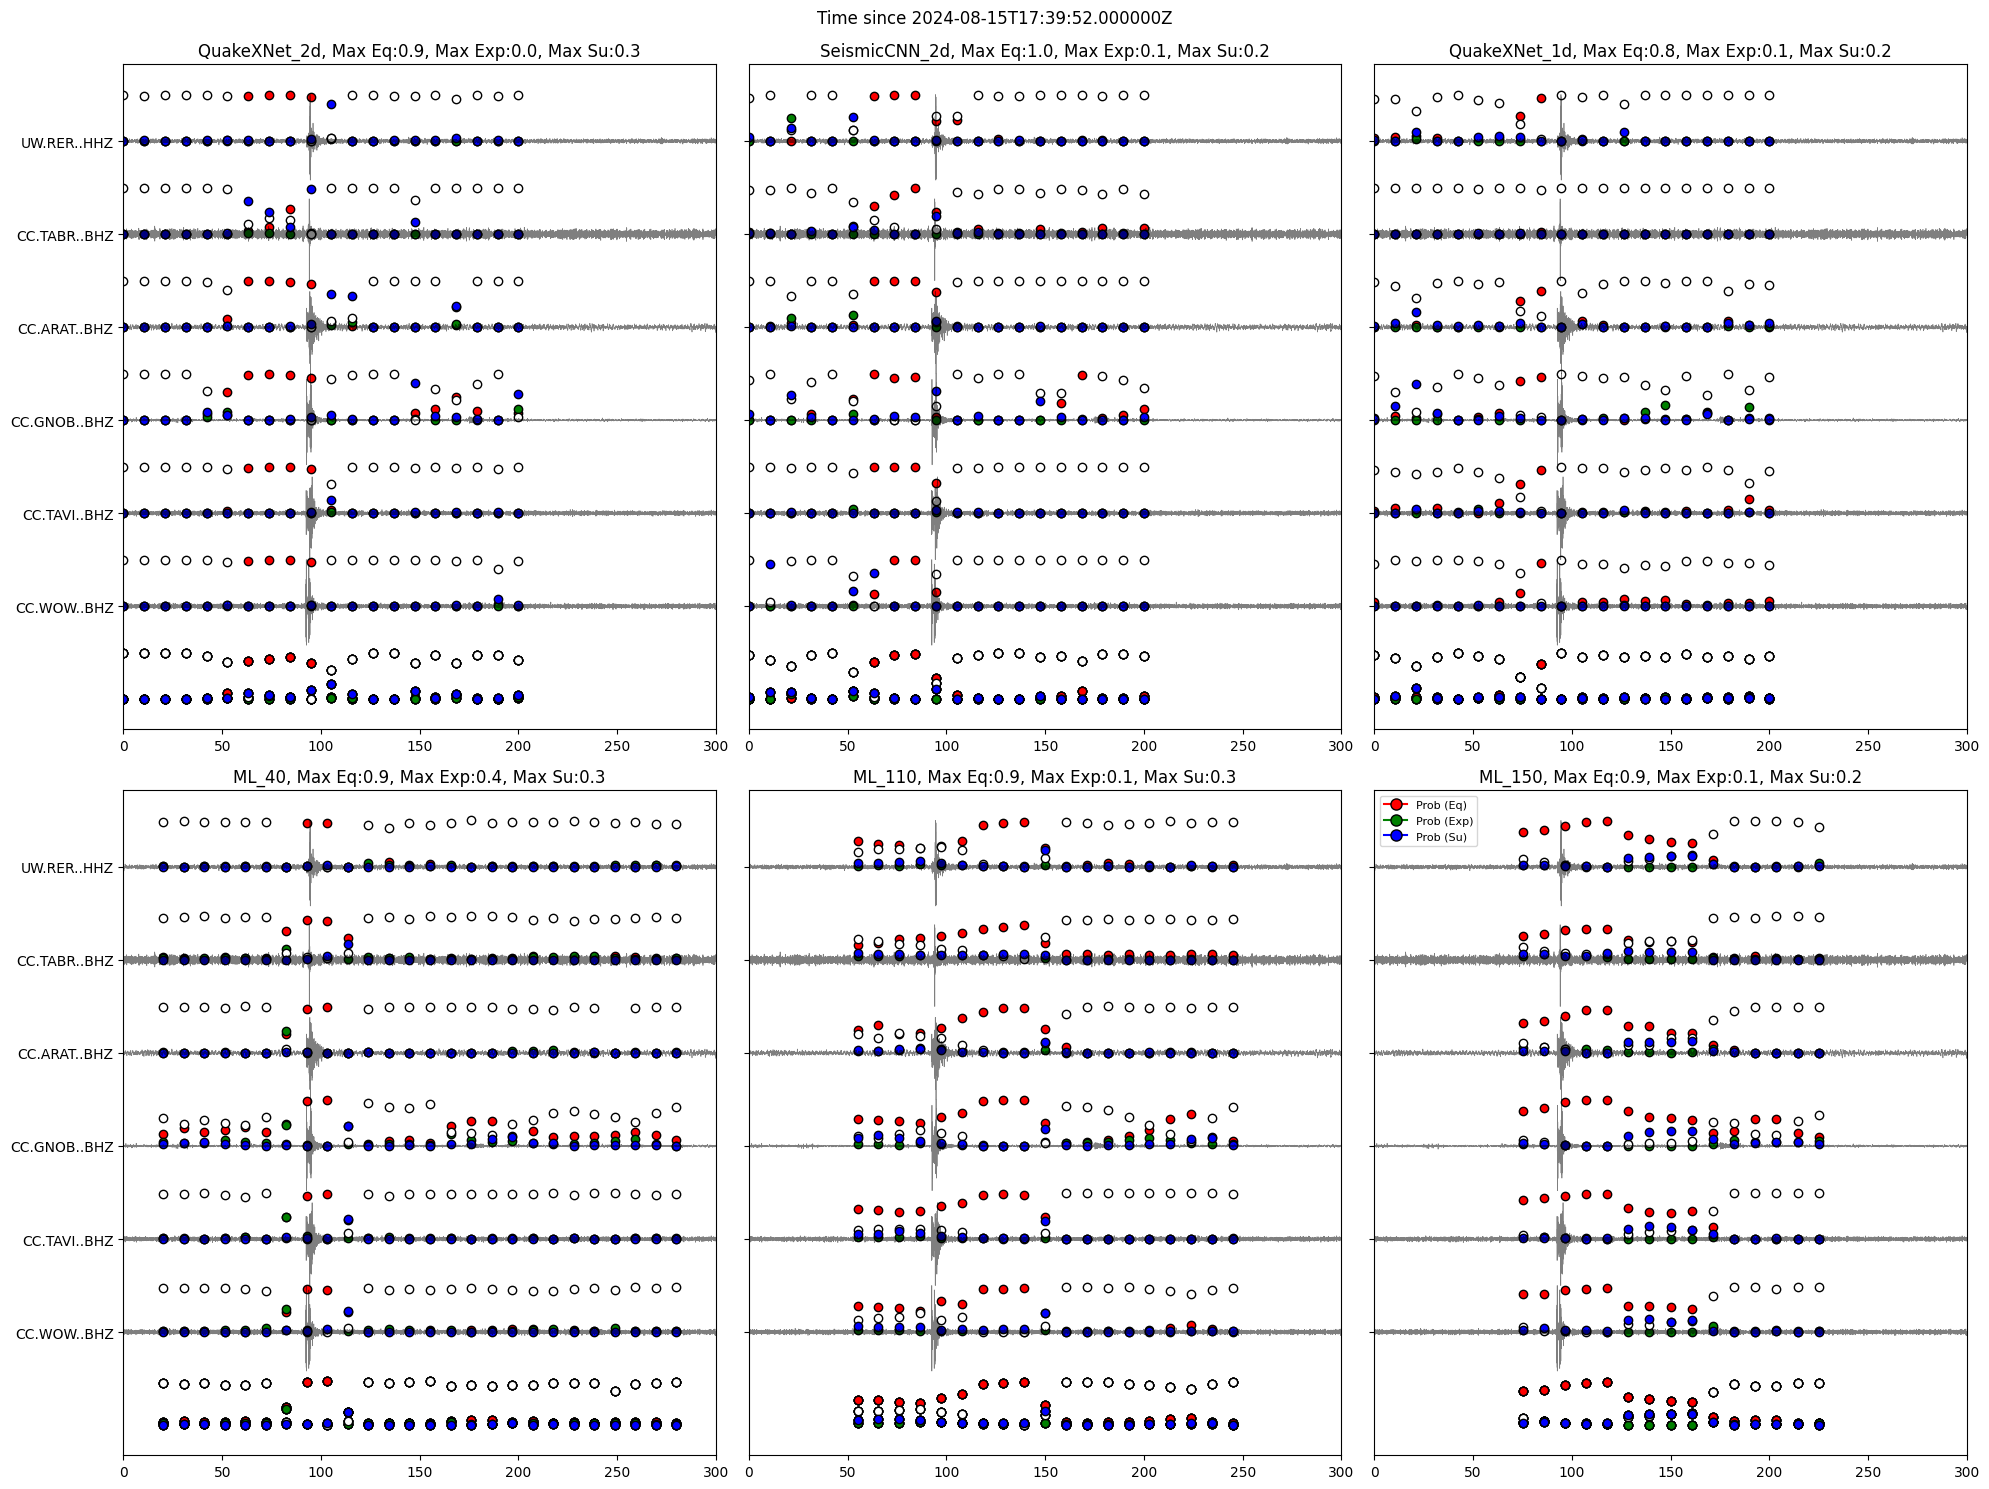

In [44]:
stn_probs_dl = [(stn_probs_quakexnet_2d, 'QuakeXNet_2d'), (stn_probs_seismiccnn_2d, 'SeismicCNN_2d'), (stn_probs_quakexnet_1d, 'QuakeXNet_1d')]
stn_probs_ml = [(stn_probs_ml_40, 'ML_40', 40), (stn_probs_ml_110, 'ML_110', 110), (stn_probs_ml_150, 'ML_150', 150)]
plot_all_model_probs(stn_probs_dl, stn_probs_ml, big_reshaped_data, orig_sr, start_time, end_time, big_station_ids)


## Plotting probabilities from any single model

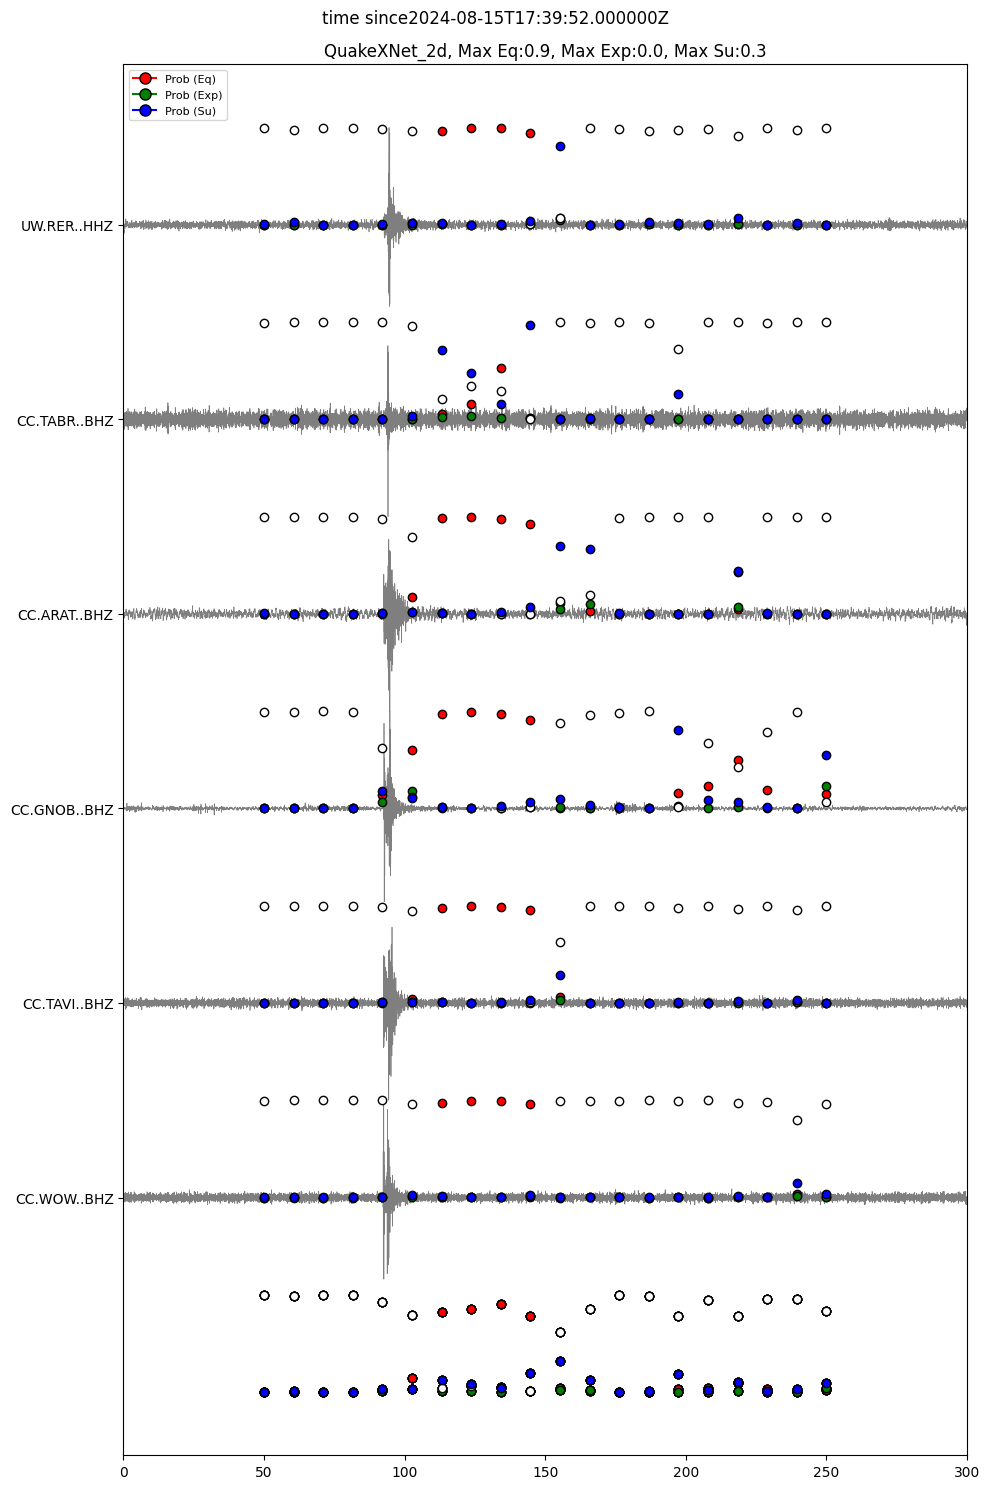

In [45]:
## Plotting any deep learning model
stn_probs = [(stn_probs_quakexnet_2d, 'QuakeXNet_2d', 100)]
plot_single_model_probs(stn_probs,  big_reshaped_data, orig_sr, start_time, end_time, big_station_ids, fig_size = (10, 15))


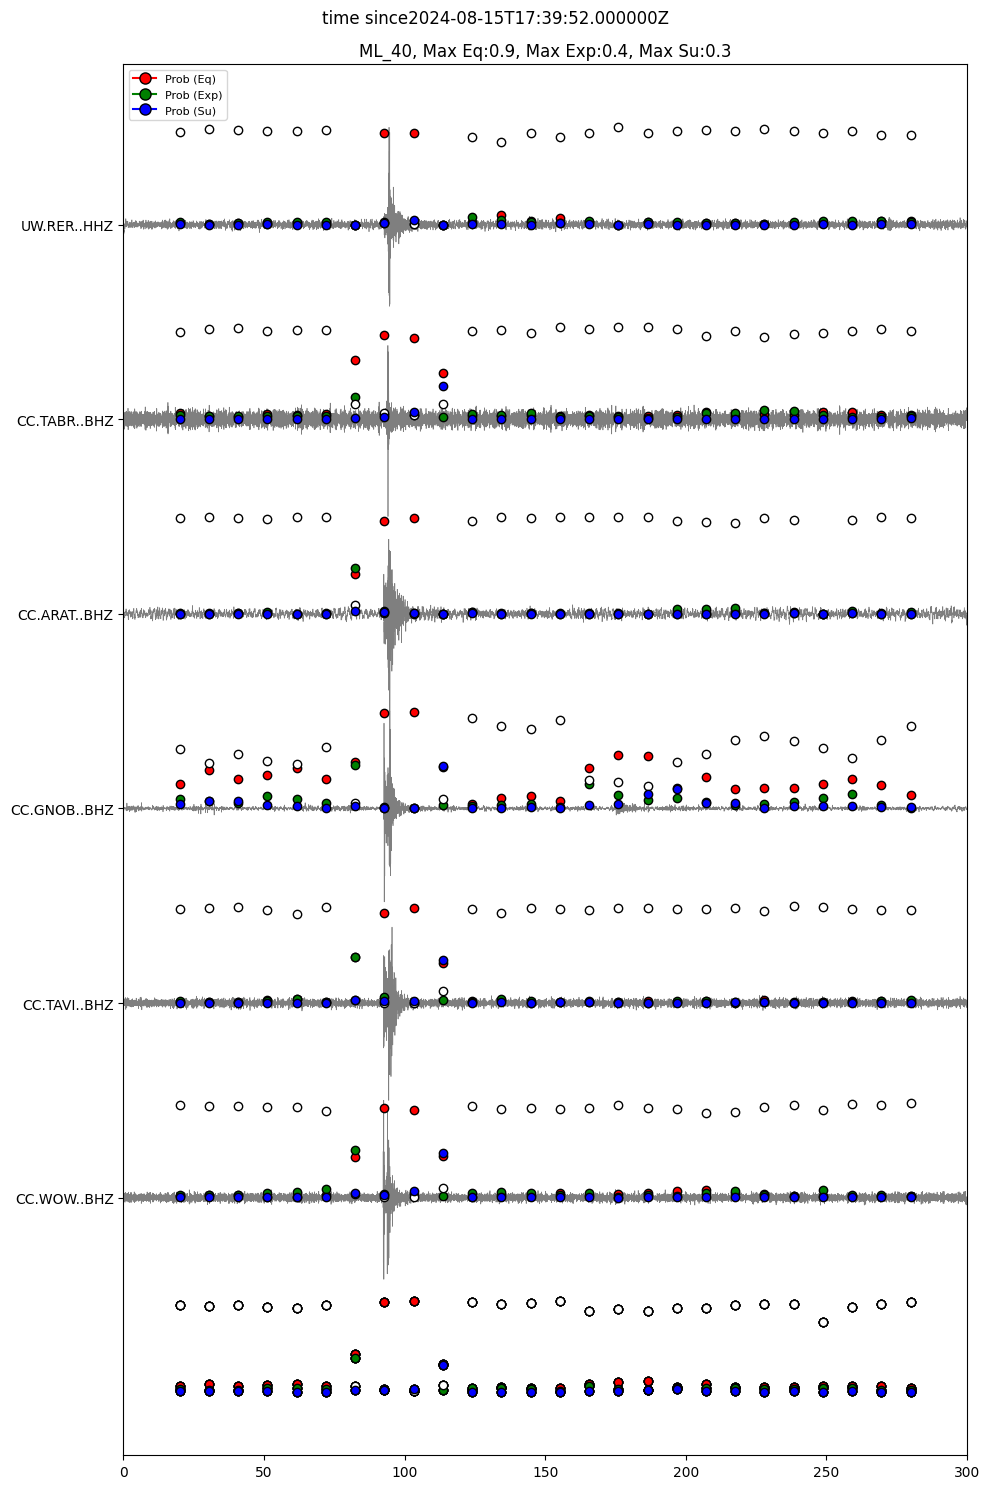

In [46]:
## Plotting any ML model
stn_probs = [(stn_probs_ml_40, 'ML_40', 40)]
plot_single_model_probs(stn_probs,  big_reshaped_data, orig_sr, start_time, end_time, big_station_ids, fig_size = (10, 15))


## Testing it on debris flow event

There was a group of debris flows that occurred at Mount St. Helens that was associated with a minor atmospheric river event on October 27, 2024 (UTC).


In [47]:
start_time = obspy.UTCDateTime(2024, 10, 27, 9, 48, 0) - 100
end_time = start_time + 3000
        
stations_id = ['UW.SHW','CC.SWF2']

location = "*"

In [49]:
# Initialize client for accessing IRIS web services
client = Client("IRIS")

# Define parameters for signal processing
orig_sr = 100  # Original sampling rate in Hz
new_sr = 50    # New sampling rate in Hz
stride = 10 * orig_sr  # Stride value for processing windows (10 times original sampling rate)
lowpass = 1  # Lowpass filter cutoff frequency in Hz
highpass = 20  # Highpass filter cutoff frequency in Hz
window_length = 100  # Length of the window for processing in samples
channel_patterns = ["EH", "BH", "HH"]  # Channel patterns to filter

# Function to process and compute probabilities for seismic models
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    """
    This function computes the probabilities for a given model, station data, and time window.
    
    Args:
        model: The model used for classification (e.g., deep learning or machine learning).
        stations_id: List of station IDs for data collection.
        location: Location of the station (wildcard "*" to match all locations).
        start_time: Start time of the seismic event (obspy.UTCDateTime object).
        end_time: End time of the seismic event (obspy.UTCDateTime object).
        one_d: Boolean indicating whether the model is 1D or 2D.
        model_type: Type of the model, either 'dl' for deep learning or 'ml' for machine learning.
        filename: Name of the output file to save results.
    
    Returns:
        tuple: Processed probabilities and other output data.
    """
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )

# Compute probabilities for different deep learning models

# 1D model: QuakexNet
stn_probs_quakexnet_1d, _, big_station_ids = process_model(
    model_quakexnet_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: QuakexNet
stn_probs_quakexnet_2d, big_reshaped_data, _ = process_model(
    model_quakexnet_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 1D model: SeismicCNN
stn_probs_seismiccnn_1d, _, _ = process_model(
    model_seismiccnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: SeismicCNN
stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# Machine Learning model probabilities
# The model parameter is irrelevant for ML models (use any model)
model = model_quakexnet_1d  # Example ML model

# 40 Hz frequency model (ML)
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)

# 110 Hz frequency model (ML)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)

# 150 Hz frequency model (ML)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:04<00:04,  4.34s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:03<00:03,  3.96s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:03<00:03,  3.17s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:03<00:03,  3.25s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:22<00:22, 22.58s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:23<00:23, 23.77s/it]

Reshaped data: (1, 3, 300000)


  0%|          | 0/2 [00:00<?, ?it/s]

Reshaped data: (1, 3, 300000)


 50%|█████     | 1/2 [00:25<00:25, 25.93s/it]

Reshaped data: (1, 3, 300000)


100%|██████████| 2/2 [00:51<00:00, 25.62s/it]


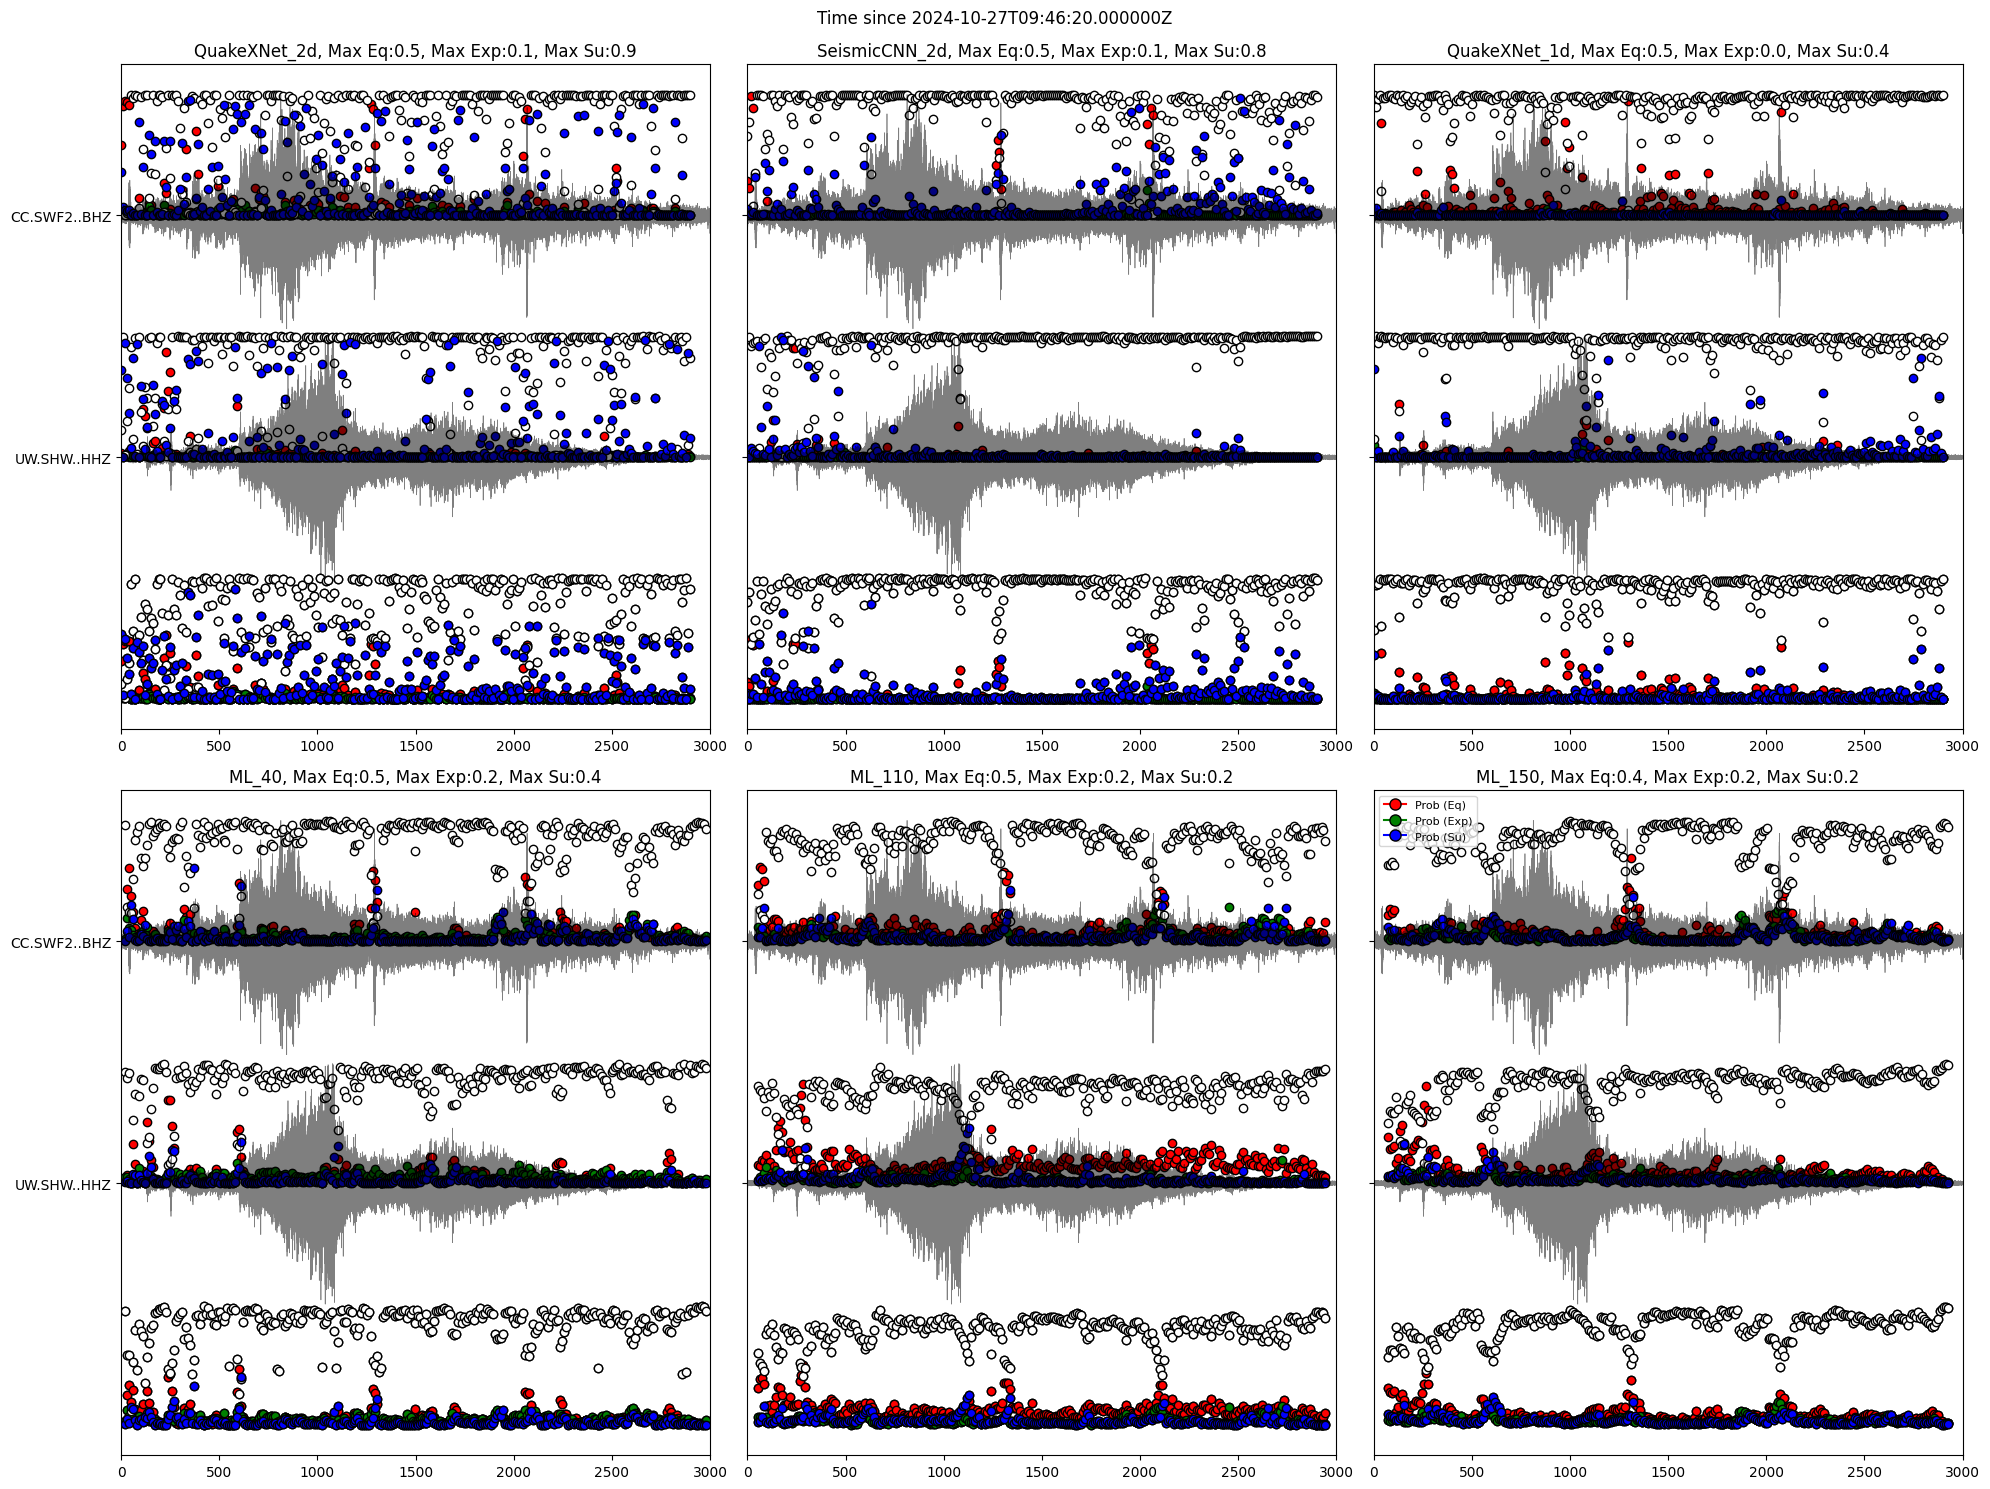

In [50]:
stn_probs_dl = [(stn_probs_quakexnet_2d, 'QuakeXNet_2d'), (stn_probs_seismiccnn_2d, 'SeismicCNN_2d'), (stn_probs_quakexnet_1d, 'QuakeXNet_1d')]
stn_probs_ml = [(stn_probs_ml_40, 'ML_40', 40), (stn_probs_ml_110, 'ML_110', 110), (stn_probs_ml_150, 'ML_150', 150)]
plot_all_model_probs(stn_probs_dl, stn_probs_ml, big_reshaped_data, orig_sr, start_time, end_time, big_station_ids)


## Deleting the big downloaded model files

In [35]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)